In [ ]:
!pip install netCDF4 # Install package for pulling data from NBDC website
!pip install statsmodels #Autoregression algorithm

In [ ]:


import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tarfile
import netCDF4
import xarray
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
from functools import reduce
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Upload files

In [ ]:
# Pulls data direct from buoy database. 
#Adapted from NOAA Pandas tutorial: http://webcache.googleusercontent.com/search?q=cache:Zuh-Sz3S_OkJ:ftp://polar.ncep.noaa.gov/ngmmf_python/Pandas_Tutorial.pdf+&cd=5&hl=en&ct=clnk&gl=us  

# Time period of interest
year=2019
start_month=1
end_month=12
# List the buoy IDs that you want to look at. These are a couple around Hawai'i
buoy_ID_list = ["51002", "51004", "51208", "51201", "51000", "46006", "52201"]
target_buoy = "51201"

# List containing data pulled from each buoy:
buoy_data_list = []

for i, buoyID in enumerate(buoy_ID_list):
  url='https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/'+buoyID+'/'+ \
  buoyID+'h'+str(year)+'.nc'
  ncdata=xarray.open_dataset(url,decode_times=True)

  startat=datetime(year,start_month,1)
  stopat=startat+relativedelta(months= end_month - start_month)-relativedelta(days=1)

  # take data from time slice of interest and convert to data frame
  data = ncdata.sel(time=slice(startat,stopat)).to_dataframe()


  # Reset index from latitutde/longitude to datetime. Note that we have to round to the nearest hour. 
  # This is because we are merging dataframes based on datetime later and they must be aligned exactly
  data=data.reset_index()
  data.index=data['time'].dt.round('1H')
  data.index.name='datetime'

  # Now that we've rounded to the hour, we only want to keep one hourly reading for our time series
  data['datetime_col'] = data.index
  data.drop_duplicates(subset=['datetime_col'], keep="first", inplace=True)


  #Fill in NaN/NaT values. Hopefully since we round to the hour, we will still have a datapoint for that hour
  data.fillna(method='bfill', inplace=True)
  data.fillna(method='ffill', inplace=True)

  # List of parameters for our model. Drop parameters by deleting their names here.
  params={'wave_height': 'wave_height_' + buoyID, 'mean_wave_dir': 'mean_wave_dir_' + buoyID,
        'sea_surface_temperature': 'sea_surface_temperature_' + buoyID}
  dropkeys=[key for key in data if key not in params]
  data.drop(dropkeys,axis=1,inplace=True)
  data.rename(columns=params,inplace=True)

  buoy_data_list.append(data)


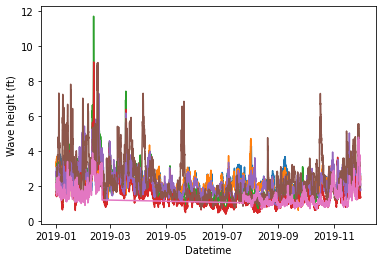

In [ ]:
# Loop through the dataset and print wave height plot
for i, data in enumerate(buoy_data_list):
  plt.xlabel('Datetime')
  plt.ylabel('Wave height (ft)')
  plt.plot(data["wave_height_" + buoy_ID_list[i]])

In [ ]:
# Take the dataframes from each buoy and merge them horizontally
# so for each row (time) we have the relevant data from each buoy

merged_data = reduce(lambda  left,right: pd.merge(left,right,on=['datetime'],
                                            how='outer'), buoy_data_list)


# Do another NaN/NaT fill in case some of the datetime indexes are missing
# backfill and forward fill in case first/last values are missing
merged_data = merged_data.asfreq('H')
merged_data.fillna(method='ffill', inplace=True)
merged_data.fillna(method='bfill', inplace=True)
merged_data.dropna(axis=1, inplace=True) #drop columns that contain NaN

**TIME-SHIFTED RANDOM FOREST REGRESSION**

Minimum time delay: 3 hours
Maximum time delay: 29 hours


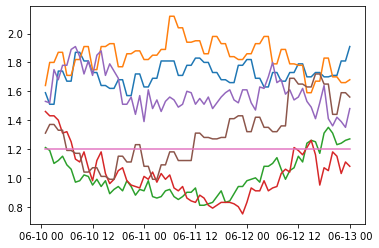

In [ ]:
#TIME SHIFTING 

#Graph a small subset of buoy data to identify time lag
subset = merged_data[["wave_height_" + ID for ID in buoy_ID_list]].loc[datetime(2019,6,10, 1): datetime(2019,6,13, 0)]
plt.plot(subset)

#calculates delay of wave peaks and shift data
min_delay = float("inf")
max_delay = 0
delay_dict = {}
shifted_datalist = [merged_data[["wave_height_" + target_buoy, "mean_wave_dir_" + target_buoy, "sea_surface_temperature_" + target_buoy]]]
for ID in buoy_ID_list:
  if ID != target_buoy:
    delay = merged_data["wave_height_" + target_buoy].argmax() - merged_data["wave_height_" + ID].argmax()
    if delay >= 0:
      delay_dict[ID] = delay
      shifted_datalist.append(merged_data[["wave_height_" +ID, "mean_wave_dir_" + ID, "sea_surface_temperature_" +ID]].shift(delay))
      if delay < min_delay:
        min_delay = delay
      if delay > max_delay:
        max_delay = delay

print("Minimum time delay: " + str(min_delay) + " hours")
print("Maximum time delay: " + str(max_delay) + " hours")
shifted_data = reduce(lambda  left,right: pd.merge(left,right,on=['datetime'], how='outer'),shifted_datalist).dropna()

Results
----------------------------
29 hour forecast.
Mean Error: 0.15618526816184322 feet.
Accuracy = 83.13961439062393


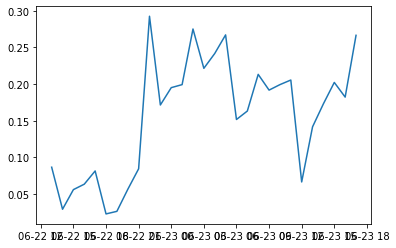

In [ ]:
# Train and Test Timeshifted Model

from sklearn.ensemble import RandomForestRegressor
# creation of X and Y to partition into train/test
#X is input; Y is true value. dropping what we trying to predict from input
X = shifted_data.drop("wave_height_" + target_buoy, axis=1)
Y = shifted_data["wave_height_" + target_buoy]

#Evaluates results of prediction
def evaluate_results(predictions, test_labels):
    errors = abs(predictions - test_labels)
    mean_percent_err = 100 * np.mean(abs(predictions - test_labels)/ test_labels)
    accuracy = 100 - mean_percent_err
    print("Results")
    print("----------------------------")
    print(str(len(predictions)) + " hour forecast.")
    print("Mean Error: " + str(np.mean(errors)) + " feet.")
    print("Accuracy = " + str(accuracy))
    plt.plot(errors)

#iterate through the buoys starting with the smallest delay and perform regression 
predictions = []
prev = 0
for ID in sorted(delay_dict.keys()):
  #gathering delay for each buoy
  delay = delay_dict[ID]
  #random forest regression
  #we can only predict as far as delay. start with furthest delay. only regression
  X_train, X_test = X[0:len(X)-max_delay], X[len(X)-max_delay+prev:len(X)-max_delay+delay]
  y_train, y_test = Y[0:len(Y)-max_delay], Y[len(Y)-max_delay+prev:len(Y)-max_delay+delay]
  rf = sklearn.ensemble.RandomForestRegressor(n_estimators = 150, criterion='mse')
  rf.fit(X_train, y_train)
  predictions.append(rf.predict(X_test))
  #figure out why we dropping
  X.drop(["wave_height_" + ID, "mean_wave_dir_" + ID, "sea_surface_temperature_" + ID], axis=1, inplace=True)
  prev = delay

#concatenate predictions and print results
predictions = np.concatenate(predictions, axis=0)
evaluate_results(predictions, Y[len(Y)-max_delay:len(Y)])


BASELINE MODEL USING ARIMA

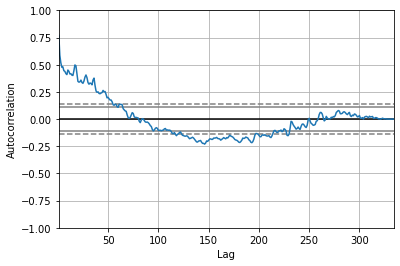

Model Performance
Average Error: 0.2559 feet.
Accuracy = 85.78%.


In [ ]:
targetbuoy_waveheight = buoy_data_list[3]["wave_height_51201"]

#fill in missing datetimes in dataframe
r = pd.date_range(start=targetbuoy_waveheight.index.min(), end=targetbuoy_waveheight.index.max())
targetbuoy_waveheight = targetbuoy_waveheight.reindex(r, fill_value=0)
data.fillna(method='bfill', inplace=True)

#plot correlation to estimate parameters for model
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(targetbuoy_waveheight)
plt.show()

# train model and predict
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(targetbuoy_waveheight.loc[datetime(2019,9,1, 0):datetime(2019,10,1, 0)], order=(3,0,0))
model_fit = model.fit()
predictions = model_fit.predict(start = datetime(2019,10,1, 0), end = datetime(2019,10,2, 0))

# evaluate prediction
true_values = targetbuoy_waveheight.loc[datetime(2019,10,1, 1): datetime(2019,10,10, 0)]
errors = abs(predictions - true_values)
mape = 100 * np.mean(errors / true_values)
accuracy = 100 - mape
print('Model Performance')
print('Average Error: {:0.4f} feet.'.format(np.mean(errors)))
print('Accuracy = {:0.2f}%.'.format(accuracy))


